In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
#!pip install torch torchvision
#import torch
from sklearn.svm import SVC

In [2]:
n_gen = 100
n_samples = 2*n_gen

In [3]:
data_pos = np.random.multivariate_normal(mean=np.array((-1,-1)), cov=np.eye(2)*0.5, size=n_gen)
data_ne = np.random.multivariate_normal(mean=np.array((1.5,1.5)), cov=np.eye(2)*0.5,size=n_gen)

/tmp/ipykernel_3136/1922499333.py:1: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(data_pos[:,0], data_pos[:,1], 'bo', marker='.', color='b')
/tmp/ipykernel_3136/1922499333.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(data_pos[:,0], data_pos[:,1], 'bo', marker='.', color='b')
/tmp/ipykernel_3136/1922499333.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(data_ne[:,0], data_ne[:,1], 'bo', marker='.', color='r')
/tmp/ipykernel_3136/1922499333.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot

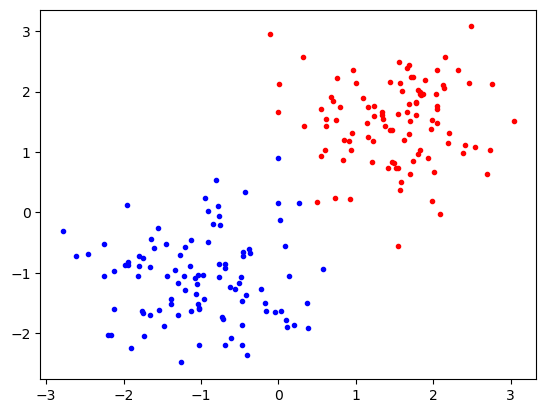

In [4]:
plt.plot(data_pos[:,0], data_pos[:,1], 'bo', marker='.', color='b')
plt.plot(data_ne[:,0], data_ne[:,1], 'bo', marker='.', color='r')

In [5]:
whole_data = np.vstack((data_pos,data_ne))
labels = np.hstack((np.ones(int(n_gen/2)),np.ones(n_gen)*-1,np.ones(int(n_gen/2))*-1))

In [6]:
df = pd.DataFrame(whole_data)
df.columns = ['x1','x2']
df['labels'] = labels

In [7]:
whole_space_x = np.random.uniform(low=-4,high=4,size=10000)
whole_space_y = np.random.uniform(low=-3,high=3,size=10000)

In [8]:
whole_space_x = whole_space_x.reshape(10000,1)
whole_space_y = whole_space_y.reshape(10000,1)
whole_space = np.hstack((whole_space_x,whole_space_y))

In [9]:
svm_test = SVC(kernel='sigmoid',probability=True).fit(X=df.to_numpy()[:,:2],y=df.to_numpy()[:,2])

In [10]:
probas = svm_test.predict_proba(whole_space)

In [11]:
probas.shape

(10000, 2)

In [12]:
probas

array([[0.72795227, 0.27204773],
       [0.71366002, 0.28633998],
       [0.79814406, 0.20185594],
       ...,
       [0.69590089, 0.30409911],
       [0.53714505, 0.46285495],
       [0.97980215, 0.02019785]])

/tmp/ipykernel_3136/2023409366.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(data_pos[:,0], data_pos[:,1], 'bo', marker='.', color='b')
/tmp/ipykernel_3136/2023409366.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(data_pos[:,0], data_pos[:,1], 'bo', marker='.', color='b')
/tmp/ipykernel_3136/2023409366.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(data_ne[:,0], data_ne[:,1], 'bo', marker='.', color='r')
/tmp/ipykernel_3136/2023409366.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.

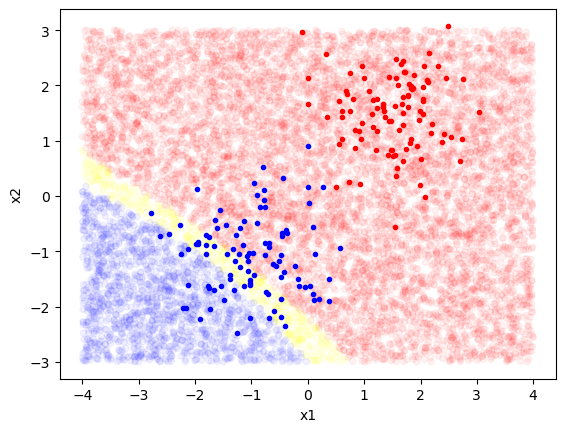

In [13]:
colors = np.empty(10000)
for i in range(10000):
    if probas[i,0]<=0.6 and probas[i,1]<=0.6:
        colors[i] = 0
    elif probas[i,0] >= probas[i,1]:
        colors[i] = 1
    else:
        colors[i] = -1

test_df = pd.DataFrame(whole_space)
test_df.columns = ['x1','x2']
test_df['colors'] = colors
colors = {0:'yellow',1:'red', -1:'blue'}
color_list = [colors[group] for group in test_df['colors']]
ax = test_df.plot.scatter('x1','x2', c=color_list,alpha=0.05)
plt.plot(data_pos[:,0], data_pos[:,1], 'bo', marker='.', color='b')
plt.plot(data_ne[:,0], data_ne[:,1], 'bo', marker='.', color='r')

Now that we have the probabilities, we can compute the probability gap : $\Delta \tilde{P}(X) = P(\tilde{Y} = +1 \vert X) - P(\tilde{Y} = -1 \vert X)$.

Moreover, for small datasets (as the ones in the article and the one for material science), the cross validation isn't adequate so we can use either the definition of l as $l=\inf_{y=+1} \Delta \tilde{P}(X)$ or the mean of the n' smallest values of $\Delta \tilde{P} (X)$. In the article, the value chosen for n' is n'=3.

In [14]:
probas = svm_test.predict_proba(df.to_numpy()[:,:2])

In [15]:
probas_gap = probas[:,1] - probas[:,0]

In [16]:
df['proba_gap'] = probas_gap

In [17]:
df

,x1,x2,labels,proba_gap
0,-0.687271,-0.920128,1.0,-0.491707
1,0.105490,-1.888421,1.0,-0.379764
2,0.021954,-0.121090,1.0,-0.505141
3,-0.415175,-1.366127,1.0,-0.409033
4,-0.774285,0.104332,1.0,-0.603214
...,...,...,...,...
195,2.317744,2.356652,-1.0,-0.992434
196,2.457003,2.135450,-1.0,-0.991351
197,1.420372,0.739389,-1.0,-0.626492
198,0.497208,0.167644,-1.0,-0.382412


In [18]:
l_boundary = np.min(df[df['labels'] == 1]['proba_gap'].to_numpy())

In [19]:
bayes_relab = np.zeros(df.shape[0])
df['relab'] = bayes_relab
for i in range(df.shape[0]):
    if probas_gap[i] < l_boundary:
        df.loc[i,'relab'] = -1
    elif probas_gap[i]>=0:
        df.loc[i,'relab'] = 1
    elif df.loc[i,'labels'] == 1:
        df.loc[i,'relab'] = 1

In [20]:
svm_test.classes_

array([-1.,  1.])

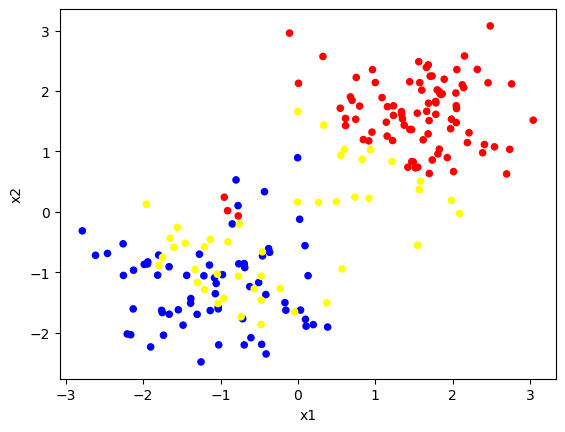

In [23]:
colors = {0:'yellow',-1:'red', 1:'blue'}
color_list = [colors[group] for group in df['relab']]
ax = df.plot.scatter('x1','x2', c=color_list)

In [26]:
df.groupby('relab').count()

,x1,x2,labels,proba_gap
relab,,,,
-1.0,88,88,88,88
0.0,45,45,45,45
1.0,67,67,67,67
